In [19]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

In [2]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

# Original Series

In [3]:
ts = pd.read_csv('original_series.csv')
ts.index = np.arange(1,len(ts)+1)

Text(0, 0.5, 'Views')

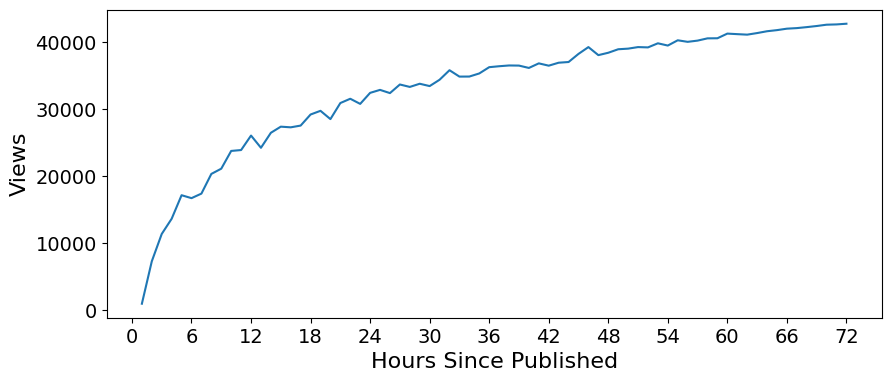

In [4]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(0,50000,10000), fontsize=14)
plt.ylabel('Views', fontsize=16)

# Original Series: $v_t$

# (1) Normalize ($v_t \rightarrow n_t$): $n_t = \frac{v_t - \mu}{\sigma}$

# (2) Exponentiate ($n_t \rightarrow e_t$): $e_t = e^{n_t}$

# (3) First Difference ($e_t \rightarrow d_t$): $d_t = e_t - e_{t-1}$

# $d_t = e^{\frac{v_t - \mu}{\sigma}} - e^{\frac{v_{t-1} - \mu}{\sigma}}$

# ------------------------------------------------------------

# (1) Normalize

In [7]:
mu = np.mean(ts.iloc[:, 0])
sigma = np.std(ts.iloc[:, 0])

norm_ts = (ts.iloc[:, 0] - mu) / sigma

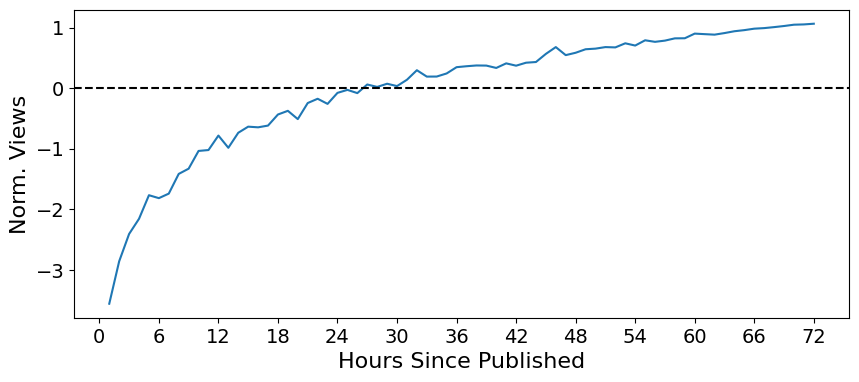

In [8]:
plt.figure(figsize=(10,4))
plt.plot(norm_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-3,2), fontsize=14)
plt.ylabel('Norm. Views', fontsize=16)

plt.axhline(0, color='k', linestyle='--')

# (2) Exponentiate

In [9]:
exp_ts = np.exp(norm_ts)

Text(0, 0.5, 'Exp. Norm. Views')

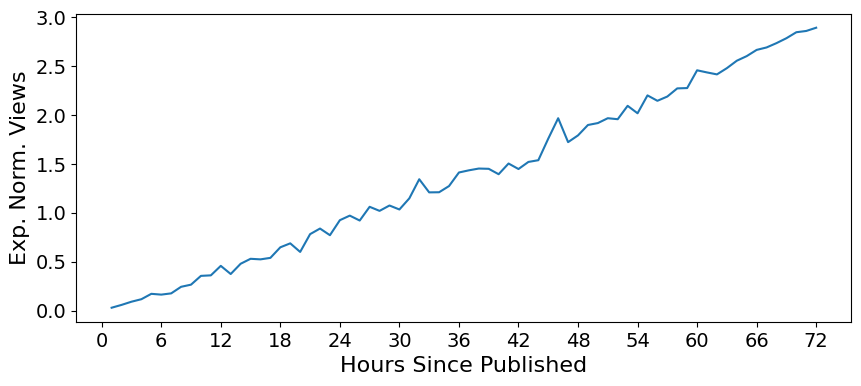

In [10]:
plt.figure(figsize=(10,4))
plt.plot(exp_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(0,3.5,.5), fontsize=14)
plt.ylabel('Exp. Norm. Views', fontsize=16)

In [11]:
perform_adf_test(exp_ts)

ADF Statistic: 1.648979
p-value: 0.997997


# (3) First Difference

In [28]:
diff_ts = exp_ts.diff().dropna()
diff_ts = diff_ts.reset_index(drop=True)


Text(0, 0.5, 'First Diff. \nExp. Norm. Views')

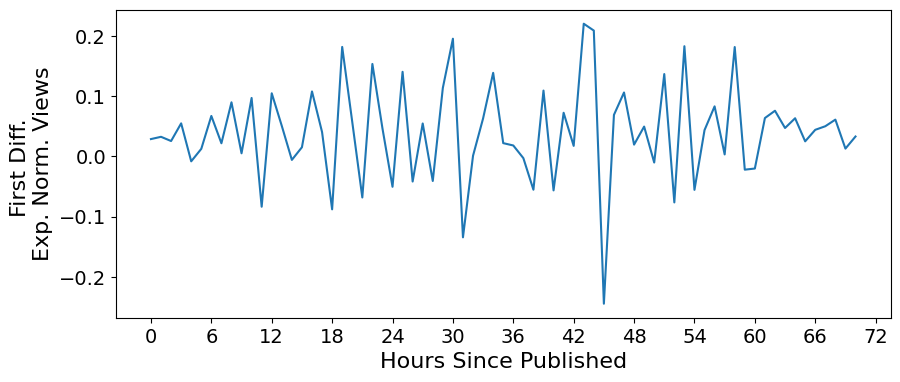

In [29]:
plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-0.2,0.3,.1), fontsize=14)
plt.ylabel('First Diff. \nExp. Norm. Views', fontsize=16)

In [30]:
perform_adf_test(diff_ts)

ADF Statistic: -4.881064
p-value: 0.000038


# Fit AR Model

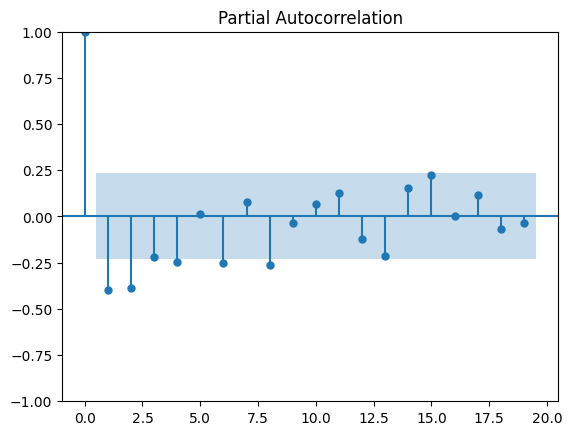

In [31]:
plot_pacf(diff_ts)
plt.show()

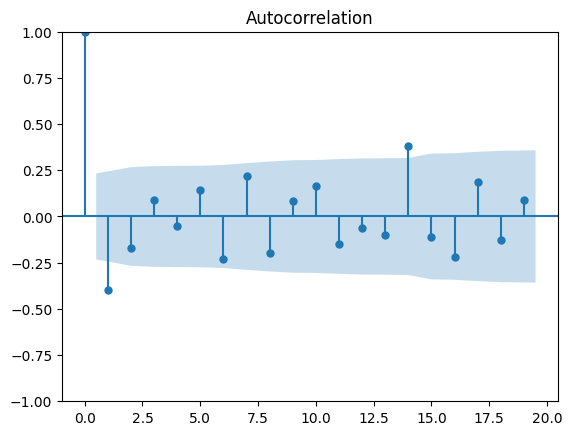

In [32]:
plot_acf(diff_ts)
plt.show()

In [33]:
#create the model
model = ARIMA(diff_ts, order=(4,0,1))

In [34]:
model_fit = model.fit()

# Predict Out 3 Hours

In [36]:
forecast_res = model_fit.get_forecast(steps=3)
predictions = forecast_res.predicted_mean.values
conf_int = forecast_res.conf_int()
lower_bound = conf_int.iloc[:, 0].values
upper_bound = conf_int.iloc[:, 1].values

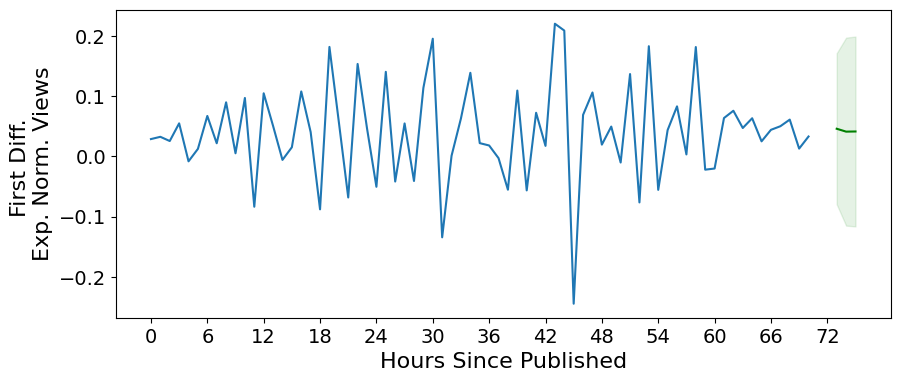

In [37]:
plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-0.2,0.3,.1), fontsize=14)
plt.ylabel('First Diff. \nExp. Norm. Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), predictions, color='g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+4), lower_bound, upper_bound, color='g', alpha=0.1)

# Undo Transformations: ($\hat{d}_{t+1} \rightarrow \hat{v}_{t+1}$)

# $\hat{v}_{t+1} = \sigma \ln(\hat{d}_{t+1} + e^{\frac{v_t - \mu}{\sigma}}) + \mu$

In [27]:
def undo_transformations(predictions, series, mu, sigma):
    first_pred = sigma*np.log(predictions[0] + np.exp((series.iloc[-1]-mu)/sigma)) + mu
    orig_predictions = [first_pred]
    
    for i in range(len(predictions[1:])):
        next_pred = sigma*np.log(predictions[i+1] + np.exp((orig_predictions[-1]-mu)/sigma)) + mu
        orig_predictions.append(next_pred)
    
    return np.array(orig_predictions).flatten()

In [28]:
orig_preds = undo_transformations(predictions, ts, mu, sigma)
orig_lower_bound = undo_transformations(lower_bound, ts, mu, sigma)
orig_upper_bound = undo_transformations(upper_bound, ts, mu, sigma)

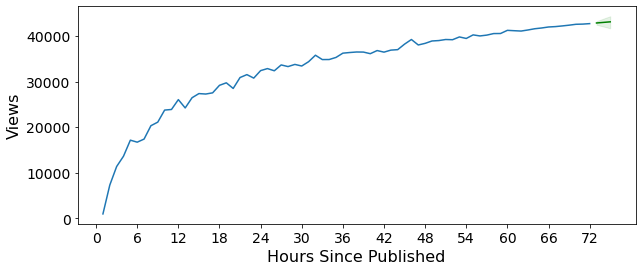

In [29]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(0,50000,10000), fontsize=14)
plt.ylabel('Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), orig_preds, color='g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+4), orig_lower_bound, orig_upper_bound, color='g', alpha=0.1)

(40000.0, 45000.0)

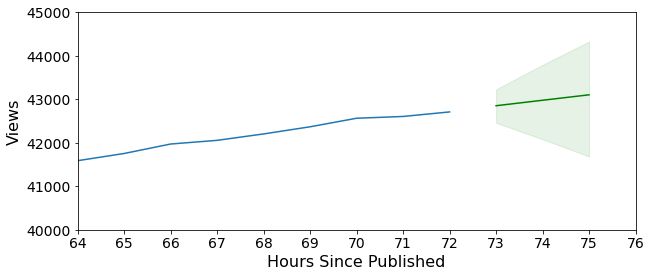

In [30]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(40000,46000,1000), fontsize=14)
plt.ylabel('Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), orig_preds, color='g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+4), orig_lower_bound, orig_upper_bound, color='g', alpha=0.1)
plt.xlim(64,76)
plt.ylim(40000, 45000)